# Определение возраста покупателей

Продуктовому магазину нужна модель, по внешности покупателя определяющая его возраст, для оценки контроля работы кассиров (следуют ли они инструкции и не продают ли алкоголь и табачные изделия лицам моложе 18 лет).

Для обучения модели используем датасет с фотографиями людей и их возрастами.

## Исследовательский анализ данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.info())
labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


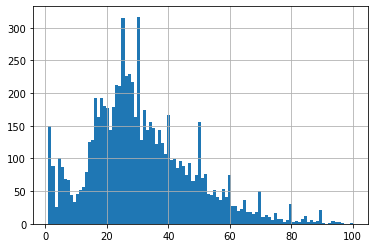

In [4]:
labels['real_age'].hist(bins=100)
plt.show()

В датасете представлены фотографии людей от 0 до 100 лет. Распределение данных стремится к нормальному, но есть дополнительный подъем в начале (эта часть графика отвечает за детей в возрасте до 10 лет). Скорее всего, при сборе данных просто было получено много детских фотографий, такие данные, что ж. Можно выбросить часть данных с детьми до, скажем, 7 лет, потому что вряд ли они часто сами ходят в супермаркеты одни и уж тем более вряд ли они предпримут попытки купить табачную/алкогольную продукцию, но лучше обойтись без этого, потому что хорошо, если модель будет знать, как классифицировать такие лица, если встретит их.

Чаще других встречаются фотографии людей в возрасте от 20 до 30 лет. Есть пики на 25, 30, 40, 50, 60, 70 и 90 годах. Возможно, некоторые фотографии при сборе данных не были размечены и их размечали вручную или с помощью другой модели, и эти круглые цифры приблизительны.

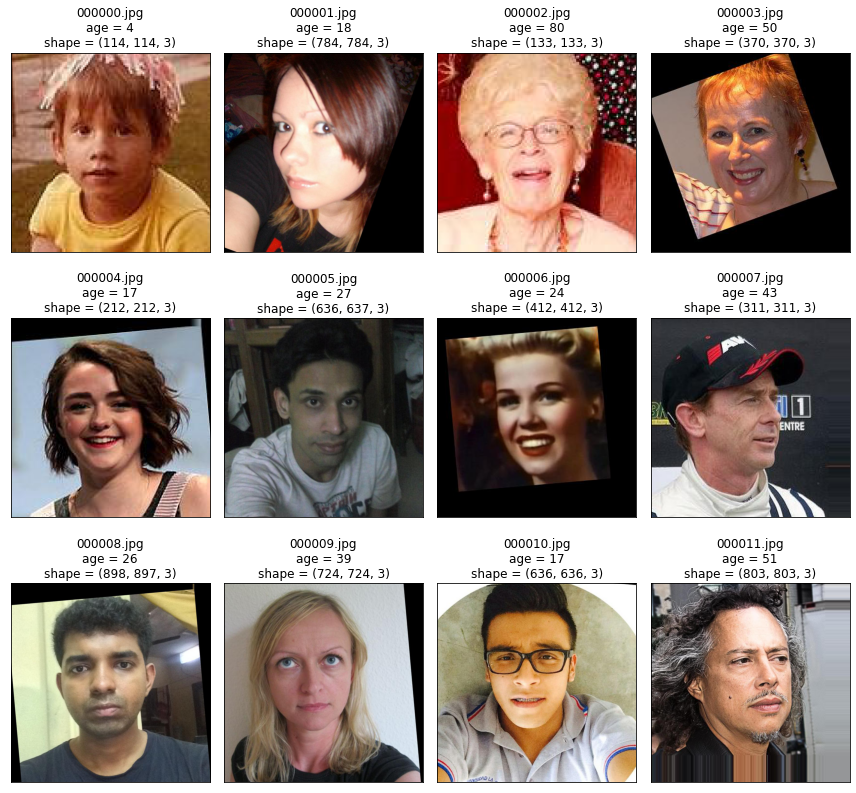

In [5]:
fig = plt.figure(figsize=(12, 12))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    
    label = labels.loc[i]
    filename = '/datasets/faces/final_files/' + label['file_name']
    image = Image.open(filename)
    plt.imshow(image)
    
    title = label['file_name']
    title = title + '\nage = ' + str(label['real_age'])
    title = title + '\nshape = ' + str(np.array(image).shape)
    plt.title(title)
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Все фотографии разного размера и качества с разной цветовой обработкой. Они приведены к некому стандарту: некоторые фотографии обрезаны, а некоторые, наоборот, достроены дублированием крайнего ряда прикселей до нужного размера. Фотографии повернуты так, чтобы лица располагались строго горизонтально, размеры лиц в кадре примерно одинаковые, то есть датасет предобработан.

## Обучение модели

В модели используем аугментацию (горизонтальные перевороты). Размер батчей - 16 (так быстрее), оптимизатор - adam, learning rate - 0.0005 (так точнее).

(Код в этом разделе запускается в отдельном GPU-тренажере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-05-12 09:30:56.488792: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-12 09:30:59.519615: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 115s - loss: 196.6907 - mae: 10.6289 - val_loss: 318.9424 - val_mae: 13.2460
Epoch 2/20
356/356 - 40s - loss: 123.1693 - mae: 8.4613 - val_loss: 197.7095 - val_mae: 10.9175
Epoch 3/20
356/356 - 40s - loss: 100.8792 - mae: 7.6708 - val_loss: 114.6512 - val_mae: 8.5075
Epoch 4/20
356/356 - 39s - loss: 86.8335 - mae: 7.1468 - val_loss: 128.0813 - val_mae: 8.5631
Epoch 5/20
356/356 - 40s - loss: 76.9108 - mae: 6.7154 - val_loss: 119.3305 - val_mae: 7.9658
Epoch 6/20
356/356 - 39s - loss: 59.2903 - mae: 5.8746 - val_loss: 303.0862 - val_mae: 13.6939
Epoch 7/20
356/356 - 39s - loss: 52.3334 - mae: 5.5871 - val_loss: 91.0872 - val_mae: 7.1980
Epoch 8/20
356/356 - 40s - loss: 46.6740 - mae: 5.2413 - val_loss: 132.3658 - val_mae: 8.5658
Epoch 9/20
356/356 - 39s - loss: 47.5551 - mae: 5.3217 - val_loss: 99.2083 - val_mae: 7.4526
Epoch 10/20
356/356 - 40s - loss: 39.3328 - mae: 4.8469 - val_loss: 102.0839 - val_mae: 7.6566
Epoch 11/20
356/356 - 40s - loss: 34.7745 - mae: 4.5142 - val_loss: 118.4873 - val_mae: 7.9538
Epoch 12/20
356/356 - 39s - loss: 27.2816 - mae: 4.0243 - val_loss: 116.4705 - val_mae: 8.4127
Epoch 13/20
356/356 - 40s - loss: 24.2323 - mae: 3.8057 - val_loss: 84.6779 - val_mae: 6.8732
Epoch 14/20
356/356 - 39s - loss: 20.9064 - mae: 3.4976 - val_loss: 80.9293 - val_mae: 6.7880
Epoch 15/20
356/356 - 40s - loss: 20.8509 - mae: 3.5127 - val_loss: 95.1215 - val_mae: 7.3722
Epoch 16/20
356/356 - 40s - loss: 19.8695 - mae: 3.4248 - val_loss: 93.9087 - val_mae: 7.3330
Epoch 17/20
356/356 - 40s - loss: 19.3548 - mae: 3.3723 - val_loss: 131.1072 - val_mae: 8.2220
Epoch 18/20
356/356 - 39s - loss: 24.9587 - mae: 3.8076 - val_loss: 102.0518 - val_mae: 7.8862
Epoch 19/20
356/356 - 40s - loss: 21.8875 - mae: 3.5959 - val_loss: 98.4577 - val_mae: 7.2645
Epoch 20/20
356/356 - 39s - loss: 16.1015 - mae: 3.1002 - val_loss: 78.6237 - val_mae: 6.6474
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 78.6237 - mae: 6.6474
Test MAE: 6.6474

```

## Анализ обученной модели

Полученная модель в среднем ошибается на 6.6 лет. По ТЗ это хорошо, но для магазина это почти фатально, потому что кассиры, продающие пиво 23-летним покупателям, проверку не пройдут, потому что модель может сказать, что покупателю было 16, а кассир балбес (в обратную сторону это тоже может сработать, если модель скажет, что 15-летнему, кажется, 21).

Чтобы улчшить качество модели, можно добавить других аугментаций (вертикальные перевороты, отражения, наклоны), увеличить размер батчей, уменьшить learning rate, добавить эпох (хотя их и так много), однако все это сильно увеличит время обучения модели.